## ING Datathon 2018 - Kernel

* Orhan İştenhiçkorkmaz, https://github.com/orhaneee
* Model was created with gradient boosting algorithms and implemented on both [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [XGBoost](https://xgboost.readthedocs.io/en/latest/)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost as xgb
import lightgbm as lgb

Observe time required for CPU to read .csv file

In [2]:
%%time

# CSV file is seperated by ';' not ','
df_data = pd.read_csv('./INGDatathonData/INGDatathonData2018.csv', delimiter=';')

CPU times: user 3.15 s, sys: 208 ms, total: 3.36 s
Wall time: 4.24 s


In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Columns: 682 entries, PRIMARY_KEY to TTL_TL_LMT_UTLZTN_DNM_FRK12
dtypes: float64(680), int64(2)
memory usage: 193.7 MB


Checking dependent variable `DEFAULT_FLAG` count and see whether this data is `balanced` or `imbalanced`
* Good info about imbalanced datas' disadvantages can be found on this [link](http://www.chioka.in/class-imbalance-problem/)
* After all, I will try to fix imbalance issue with hyperparameters of XGBoost, which can also be found on XGBoost [docs](https://xgboost.readthedocs.io/en/latest/parameter.html).

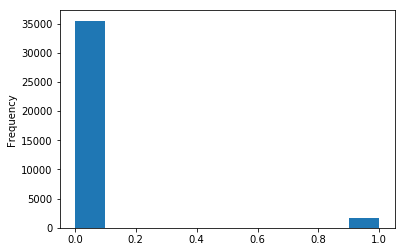

In [4]:
# Plotting histogram of value counts.
df_data['DEFAULT_FLAG'].astype(int).plot.hist()

## Feature Engineering and EDA

I always start with checking null percentage on each column.

In [5]:
# Function to create a table of missing value percentage and counts.

def calculate_missing_values(df):
    # Total missing values
    total_missing = df.isnull().sum()
    percentage = (total_missing * 100) / len(df)
    # Create a table for visualizing.
    table = pd.concat([total_missing, percentage], axis=1)
    renamed_columns = table.rename(
        columns = { 0 : 'missing values', 1 : '% of total' }
    )
    # Sorting the table.
    renamed_columns = renamed_columns[
        renamed_columns.iloc[:, 1] != 0
    ].sort_values(
        '% of total', ascending=False
    ).round(1)
    return renamed_columns

In [6]:
missing_value_table = calculate_missing_values(df_data)
missing_value_table.head(50)

,missing values,% of total
STDDEV_TTL_FX_NON_CASH_RSK12,37199,99.9
STDDEV_FX_OR_FX_NON_UTIL12,37199,99.9
STDDEV_TTL_ACCRD_INT_AMT12,37082,99.6
STDDEV_FACTORING_RSK12,37078,99.6
STDDEV_FACTORING_TL_RSK12,37078,99.6
STDDEV_TTL_FX_NON_CSH_LIMIT12,36623,98.4
FX_OR_FX_NON_UTIL_GR12,36619,98.4
SHR_FX_OR_INDX_FCT_RSK_TTL_RSK,36450,97.9
SHARE_OF_TL_FACTORING_RISK,36450,97.9
FX_OR_FX_NON_UTIL_GR6,36398,97.8


### One Hot Encoding

Since, we do not have any categorical variable column, i.e we saw it on `df_data.info()` that all fields are either float or int 64 bit. So, we do not need to encode our categorical variables.

### Correlations

In [7]:
%%time

# Find correlations between each columns
corr_matrix = df_data.corr().abs()
# Get upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print('There are %d correlated columns.' % (len(to_drop)))

df_data = df_data.drop(columns=to_drop)
print(df_data.shape)

There are 533 correlated columns.
(37224, 149)
CPU times: user 58.2 s, sys: 106 ms, total: 58.3 s
Wall time: 58.4 s


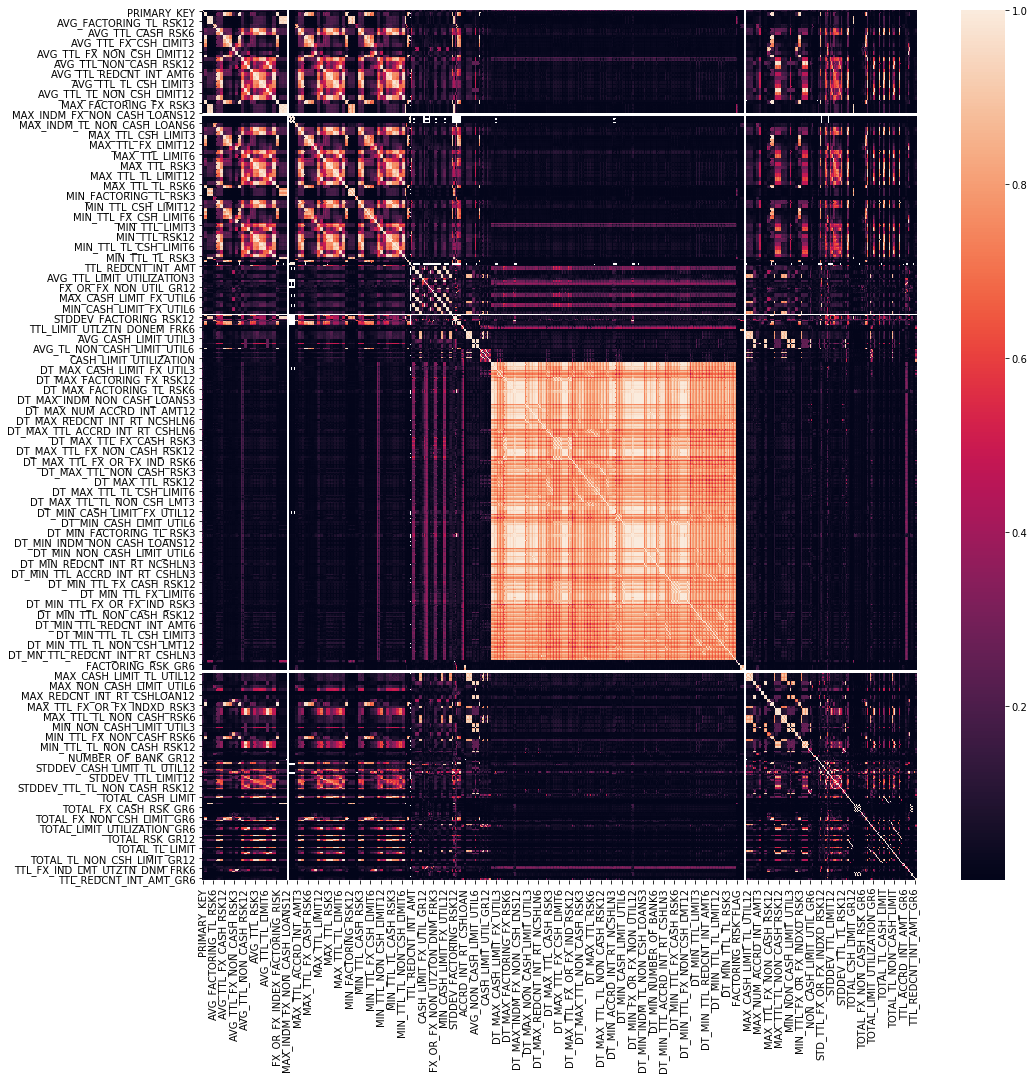

In [8]:
# Used this line to show heatmap bigger
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(corr_matrix.abs())

## Feature Selection

I think that applied machine (or deep) learning problems are all about feature selection. First, analyze the data but no too much in order to avoid overfitting.

The heatmap above tells me that:
* Not a single feature is correlated completely with class.
* Model requires the combination of features.

### Removing missing values

Removing missing values higher than a threshold is a simple feature selection technique. As we know, other most used ones are Principal Component Analysis, Recursive Feature Elimination and Feature Importance (just for tree based algorithms). In the upper cells, I showed a little bit info about missing values and percentage.

So, I will apply this firstly.

In [9]:
missing_columns = (df_data.isnull().sum() / len(df_data)).sort_values(ascending = False)
missing_columns.head(20)

STDDEV_FX_OR_FX_NON_UTIL12        0.999328
FX_OR_FX_NON_UTIL_GR12            0.983747
SHARE_OF_TL_FACTORING_RISK        0.979207
SHR_FX_OR_INDX_FCT_RSK_TTL_RSK    0.979207
FX_OR_FX_NON_UTIL_GR6             0.977810
AVG_FX_OR_FX_NON_UTIL12           0.969992
FX_OR_FX_NON_UTZTN_DNM_FRK6       0.961638
FX_OR_FX_NON_UTZTON_DNM_FRK3      0.961638
FX_OR_FX_NON_UTZTTN_DNM_FRK12     0.961638
CASH_LIMIT_FX_UTIL_GR12           0.930663
CASH_LIMIT_FX_UTIL_GR6            0.840640
AVG_CASH_LIMIT_FX_UTIL12          0.753707
TOTAL_LIMIT_UTILIZATION_GR12      0.728374
STDDEV_TTL_LIMIT_UTILIZATION12    0.724156
STD_TL_NON_CASH_LIMIT_UTIL12      0.671690
CASH_LIMIT_FX_UTLZTN_DNM_FRK3     0.668843
CASH_LIMIT_FX_UTLZTN_DNM_FRK6     0.668816
CASH_LMT_FX_UTLZTN_DNM_FRK12      0.668816
NON_CASH_LIMIT_UTIL_GR12          0.584193
STDDEV_TTL_NON_CSH_LIMIT12        0.568665
dtype: float64

In [10]:
missing_columns = missing_columns.index[missing_columns > 0.75]
print(missing_columns)

Index([u'STDDEV_FX_OR_FX_NON_UTIL12', u'FX_OR_FX_NON_UTIL_GR12',
       u'SHARE_OF_TL_FACTORING_RISK', u'SHR_FX_OR_INDX_FCT_RSK_TTL_RSK',
       u'FX_OR_FX_NON_UTIL_GR6', u'AVG_FX_OR_FX_NON_UTIL12',
       u'FX_OR_FX_NON_UTZTN_DNM_FRK6', u'FX_OR_FX_NON_UTZTON_DNM_FRK3',
       u'FX_OR_FX_NON_UTZTTN_DNM_FRK12', u'CASH_LIMIT_FX_UTIL_GR12',
       u'CASH_LIMIT_FX_UTIL_GR6', u'AVG_CASH_LIMIT_FX_UTIL12'],
      dtype='object')


In [11]:
df_data = df_data.drop(columns=missing_columns)

In [12]:
df_data.shape

(37224, 137)

### Keep Most Important Features

In many large datasets, building a model with a gradient boosting algorithm, we need to remove 0 important features in order to increase performance on training. I will not do this due to fact that we do not have a large dataset.

## Training the Model

Split and GridSearchCV to find best hyperparameters.

In [13]:
# See last feature engineered data.

df_data.head(10)

,PRIMARY_KEY,DEFAULT_FLAG,AVG_FACTORING_FX_RSK12,AVG_FACTORING_RSK12,AVG_TTL_ACCRD_INT_AMT12,AVG_TTL_ACCRD_INT_AMT3,AVG_TTL_CASH_RSK12,AVG_TTL_CSH_LIMIT12,AVG_TTL_FX_CSH_LIMIT12,AVG_TTL_FX_LIMIT12,...,TOTAL_RSK_GR12,TOTAL_RSK_GR6,TOTAL_TL_NON_CSH_LIMIT_GR6,TOTAL_TL_RSK_GR12,TTL_ACCRD_INT_AMT_GR12,TTL_ACCRD_INT_AMT_GR6,TTL_INDM_FX_OR_FX_NONCASH_LOAN,TTL_REDCNT_INT_AMT_GR12,TTL_REDCNT_INT_AMT_GR6,TTL_TL_LMT_UTLZTN_DNM_FRK12
0,1,0,0.000000,0.0,0.000000,0.000000,18613.333333,2.773333e+05,0.000000,16200.000000,...,1.440494,-0.083473,-0.082500,1.440494,0.0,0.000000,0.0,0.000000,0.000000,5.0
1,4,0,0.000000,0.0,0.000000,0.000000,425153.583330,1.272383e+06,0.000000,0.000000,...,0.257247,-0.059580,0.054618,0.257247,0.0,0.000000,0.0,7.395522,1.002670,10.0
2,5,0,0.000000,0.0,36.333333,0.000000,685757.750000,1.240202e+06,0.000000,0.000000,...,0.536290,0.123511,0.135666,0.536290,0.0,0.000000,0.0,1.461333,0.176171,1.0
3,10,0,8192.916667,0.0,0.000000,0.000000,16296.250000,3.122067e+04,8192.916667,8192.916667,...,16.425287,-0.042929,0.000000,16.425287,0.0,0.000000,0.0,0.000000,-0.110553,0.0
4,11,0,0.000000,0.0,0.000000,0.000000,6332.833333,2.572382e+05,0.000000,0.000000,...,-0.271977,-0.142173,-0.169611,-0.271977,0.0,0.000000,0.0,0.000000,0.000000,10.0
5,12,0,0.000000,0.0,0.000000,0.000000,80703.500000,9.950833e+05,0.000000,0.000000,...,5.830469,0.464139,0.000000,5.830469,0.0,0.000000,0.0,0.000000,0.000000,3.0
6,13,0,0.000000,0.0,22.166667,8.000000,19936.666667,2.550242e+04,0.000000,0.000000,...,0.316257,-0.099649,0.000000,0.316257,0.0,0.000000,0.0,1.181818,-0.815385,5.0
7,14,0,0.000000,0.0,16.000000,0.000000,266443.833330,4.184968e+05,0.000000,0.000000,...,0.067462,0.087706,0.078712,0.067462,0.0,0.000000,0.0,0.244318,0.098662,4.0
8,16,0,5250.833333,0.0,276.750000,82.666667,151937.916670,2.849966e+05,5250.833333,5250.833333,...,0.180009,0.192864,-0.287693,0.090207,0.0,-0.630303,0.0,0.584884,-0.025036,0.0
9,17,0,20185.000000,0.0,110.250000,99.000000,266101.750000,5.494642e+05,20185.000000,20185.000000,...,0.557163,0.082101,0.364063,0.545648,7.0,0.000000,0.0,1.751790,1.550885,10.0


In [14]:
# Main data with dependent variable and features.
# Dropped IDs also.

y = df_data['DEFAULT_FLAG']
X = df_data.drop(columns=['PRIMARY_KEY', 'DEFAULT_FLAG'])

In [15]:
# Since we do not have validation and test set,
# I divided it with train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
# Printing the shapes.

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26056, 135)
(11168, 135)
(26056,)
(11168,)


In [17]:
# Build a predefined LGBBMClassifier instance with predefined params.
# The most important parameter here is the ratio of scale_pos_weight
# on unbalanced classes but, I did not use it to show something.

lgb_model = lgb.LGBMClassifier(
    learning_rate =0.007,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=5,
    gamma=0.4,
    subsample=0.55,
    colsample_bytree=0.85,
    reg_alpha=0.005,
    nthread=4,
    seed=27
)

# Print its default parameters
print(lgb_model.get_params)

# Parameter grid to search for finding best.
# I used L1 and L2 regularization parameters
# to avoid overfitting.
param_grid = {
    'reg_alpha': [0.005, 0.001],
    'max_depth': [3, 5, 7]
}

# Create an GridSearchCV instance
grid_search = GridSearchCV(lgb_model, param_grid=param_grid, cv=5, verbose=4)

# Fit with our data and avoid overfitting with evaluation set.
# After 100 trials, if the model's auc metric does not improve,
# it stops training.
grid_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], eval_metric='auc')

# Print best values.
print(grid_search.best_score_)
print(grid_search.best_params_)

<bound method LGBMClassifier.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
        gamma=0.4, importance_type='split', learning_rate=0.007,
        max_depth=3, min_child_samples=20, min_child_weight=5,
        min_split_gain=0.0, n_estimators=1000, n_jobs=-1, nthread=4,
        num_leaves=31, objective=None, random_state=None, reg_alpha=0.005,
        reg_lambda=0.0, seed=27, silent=True, subsample=0.55,
        subsample_for_bin=200000, subsample_freq=0)>
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] reg_alpha=0.005, max_depth=3 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1]	valid_0's auc: 0.658478	valid_0's binary_logloss: 0.185976
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.674216	valid_0's binary_logloss: 0.185856
[3]	valid_0's auc: 0.673841	valid_0's binary_logloss: 0.185724
[4]	valid_0's auc: 0.678307	valid_0's binary_logloss: 0.185608
[5]	valid_0's auc: 0.6762	valid_0's binary_logloss: 0.185478
[6]	valid_0's auc: 0.675666	valid_0's binary_logloss: 0.185351
[7]	valid_0's auc: 0.673627	valid_0's binary_logloss: 0.185231
[8]	valid_0's auc: 0.673746	valid_0's binary_logloss: 0.18511
[9]	valid_0's auc: 0.673869	valid_0's binary_logloss: 0.18499
[10]	valid_0's auc: 0.673931	valid_0's binary_logloss: 0.184876
[11]	valid_0's auc: 0.676792	valid_0's binary_logloss: 0.184768
[12]	valid_0's auc: 0.681027	valid_0's binary_logloss: 0.18464
[13]	valid_0's auc: 0.684932	valid_0's binary_logloss: 0.18454
[14]	valid_0's auc: 0.685477	valid_0's binary_logloss: 0.184427
[15]	valid_0's auc: 0.688587	valid_0's binary_logloss: 0

[149]	valid_0's auc: 0.705787	valid_0's binary_logloss: 0.176932
[150]	valid_0's auc: 0.705781	valid_0's binary_logloss: 0.176897
[151]	valid_0's auc: 0.705474	valid_0's binary_logloss: 0.176866
[152]	valid_0's auc: 0.705385	valid_0's binary_logloss: 0.176834
[153]	valid_0's auc: 0.705105	valid_0's binary_logloss: 0.176812
[154]	valid_0's auc: 0.704607	valid_0's binary_logloss: 0.176785
[155]	valid_0's auc: 0.704769	valid_0's binary_logloss: 0.176756
[156]	valid_0's auc: 0.704801	valid_0's binary_logloss: 0.176729
[157]	valid_0's auc: 0.704424	valid_0's binary_logloss: 0.176702
[158]	valid_0's auc: 0.704416	valid_0's binary_logloss: 0.176686
[159]	valid_0's auc: 0.704468	valid_0's binary_logloss: 0.176665
[160]	valid_0's auc: 0.704501	valid_0's binary_logloss: 0.176635
[161]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.176616
[162]	valid_0's auc: 0.704012	valid_0's binary_logloss: 0.17659
[163]	valid_0's auc: 0.70427	valid_0's binary_logloss: 0.17656
[164]	valid_0's auc: 0.70414

[311]	valid_0's auc: 0.707091	valid_0's binary_logloss: 0.174497
[312]	valid_0's auc: 0.706752	valid_0's binary_logloss: 0.174488
[313]	valid_0's auc: 0.706381	valid_0's binary_logloss: 0.174483
[314]	valid_0's auc: 0.70633	valid_0's binary_logloss: 0.174481
[315]	valid_0's auc: 0.70678	valid_0's binary_logloss: 0.174469
[316]	valid_0's auc: 0.706375	valid_0's binary_logloss: 0.174463
[317]	valid_0's auc: 0.706807	valid_0's binary_logloss: 0.174454
[318]	valid_0's auc: 0.706758	valid_0's binary_logloss: 0.17444
[319]	valid_0's auc: 0.706758	valid_0's binary_logloss: 0.174441
[320]	valid_0's auc: 0.706834	valid_0's binary_logloss: 0.174434
[321]	valid_0's auc: 0.706834	valid_0's binary_logloss: 0.17443
[322]	valid_0's auc: 0.706814	valid_0's binary_logloss: 0.17443
[323]	valid_0's auc: 0.706584	valid_0's binary_logloss: 0.174418
[324]	valid_0's auc: 0.706539	valid_0's binary_logloss: 0.174409
[325]	valid_0's auc: 0.70661	valid_0's binary_logloss: 0.174404
[326]	valid_0's auc: 0.706597	v

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[5]	valid_0's auc: 0.683294	valid_0's binary_logloss: 0.185445
[6]	valid_0's auc: 0.684828	valid_0's binary_logloss: 0.185326
[7]	valid_0's auc: 0.683943	valid_0's binary_logloss: 0.185189
[8]	valid_0's auc: 0.683241	valid_0's binary_logloss: 0.185054
[9]	valid_0's auc: 0.683299	valid_0's binary_logloss: 0.184921
[10]	valid_0's auc: 0.685697	valid_0's binary_logloss: 0.18479
[11]	valid_0's auc: 0.685913	valid_0's binary_logloss: 0.184689
[12]	valid_0's auc: 0.687709	valid_0's binary_logloss: 0.184557
[13]	valid_0's auc: 0.688043	valid_0's binary_logloss: 0.184454
[14]	valid_0's auc: 0.688193	valid_0's binary_logloss: 0.184329
[15]	valid_0's auc: 0.695268	valid_0's binary_logloss: 0.184203
[16]	valid_0's auc: 0.695545	valid_0's binary_logloss: 0.18408
[17]	valid_0's auc: 0.69551	valid_0's binary_logloss: 0.183983
[18]	valid_0's auc: 0.695486	valid_0's binary_logloss: 0.183867
[19]	valid_0's auc: 0.696215	valid_0's binary_logloss: 0.183757
[20]	valid_0's auc: 0.696075	valid_0's binary_lo

[CV]  reg_alpha=0.005, max_depth=3, score=0.952993092863, total=   0.8s
[CV] reg_alpha=0.005, max_depth=3 ....................................
[1]	valid_0's auc: 0.671097	valid_0's binary_logloss: 0.185976
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.68794	valid_0's binary_logloss: 0.185845
[3]	valid_0's auc: 0.686174	valid_0's binary_logloss: 0.185722
[4]	valid_0's auc: 0.691691	valid_0's binary_logloss: 0.185608


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[5]	valid_0's auc: 0.692378	valid_0's binary_logloss: 0.18549
[6]	valid_0's auc: 0.696104	valid_0's binary_logloss: 0.185385
[7]	valid_0's auc: 0.699028	valid_0's binary_logloss: 0.185283
[8]	valid_0's auc: 0.695472	valid_0's binary_logloss: 0.185182
[9]	valid_0's auc: 0.698044	valid_0's binary_logloss: 0.185072
[10]	valid_0's auc: 0.697949	valid_0's binary_logloss: 0.184955
[11]	valid_0's auc: 0.699203	valid_0's binary_logloss: 0.184852
[12]	valid_0's auc: 0.698464	valid_0's binary_logloss: 0.184742
[13]	valid_0's auc: 0.700641	valid_0's binary_logloss: 0.184634
[14]	valid_0's auc: 0.700476	valid_0's binary_logloss: 0.184508
[15]	valid_0's auc: 0.700958	valid_0's binary_logloss: 0.184396
[16]	valid_0's auc: 0.698808	valid_0's binary_logloss: 0.184306
[17]	valid_0's auc: 0.698547	valid_0's binary_logloss: 0.184218
[18]	valid_0's auc: 0.699372	valid_0's binary_logloss: 0.184128
[19]	valid_0's auc: 0.699466	valid_0's binary_logloss: 0.184022
[20]	valid_0's auc: 0.698784	valid_0's binary_

[142]	valid_0's auc: 0.70309	valid_0's binary_logloss: 0.177061
[143]	valid_0's auc: 0.703442	valid_0's binary_logloss: 0.177029
[144]	valid_0's auc: 0.703301	valid_0's binary_logloss: 0.177007
[145]	valid_0's auc: 0.703225	valid_0's binary_logloss: 0.176974
[146]	valid_0's auc: 0.702777	valid_0's binary_logloss: 0.176949
[147]	valid_0's auc: 0.70278	valid_0's binary_logloss: 0.176922
[148]	valid_0's auc: 0.702917	valid_0's binary_logloss: 0.176892
[149]	valid_0's auc: 0.702994	valid_0's binary_logloss: 0.176856
[150]	valid_0's auc: 0.702997	valid_0's binary_logloss: 0.176833
[151]	valid_0's auc: 0.703144	valid_0's binary_logloss: 0.176805
[152]	valid_0's auc: 0.703051	valid_0's binary_logloss: 0.176774
[153]	valid_0's auc: 0.703034	valid_0's binary_logloss: 0.176749
[154]	valid_0's auc: 0.702988	valid_0's binary_logloss: 0.176726
[155]	valid_0's auc: 0.70331	valid_0's binary_logloss: 0.176692
[156]	valid_0's auc: 0.703309	valid_0's binary_logloss: 0.176665
[157]	valid_0's auc: 0.70338

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s


[1]	valid_0's auc: 0.675424	valid_0's binary_logloss: 0.185967
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.682598	valid_0's binary_logloss: 0.185851
[3]	valid_0's auc: 0.682379	valid_0's binary_logloss: 0.185719
[4]	valid_0's auc: 0.680603	valid_0's binary_logloss: 0.185614
[5]	valid_0's auc: 0.686417	valid_0's binary_logloss: 0.185486
[6]	valid_0's auc: 0.687335	valid_0's binary_logloss: 0.185352
[7]	valid_0's auc: 0.685742	valid_0's binary_logloss: 0.185225
[8]	valid_0's auc: 0.687169	valid_0's binary_logloss: 0.185096
[9]	valid_0's auc: 0.687529	valid_0's binary_logloss: 0.18497
[10]	valid_0's auc: 0.688149	valid_0's binary_logloss: 0.184846
[11]	valid_0's auc: 0.691524	valid_0's binary_logloss: 0.184735
[12]	valid_0's auc: 0.6903	valid_0's binary_logloss: 0.184615
[13]	valid_0's auc: 0.693138	valid_0's binary_logloss: 0.184517
[14]	valid_0's auc: 0.692111	valid_0's binary_logloss: 0.1844
[15]	valid_0's auc: 0.69352	valid_0's binary_logloss: 0

[147]	valid_0's auc: 0.705995	valid_0's binary_logloss: 0.17669
[148]	valid_0's auc: 0.706825	valid_0's binary_logloss: 0.17665
[149]	valid_0's auc: 0.707066	valid_0's binary_logloss: 0.176631
[150]	valid_0's auc: 0.707082	valid_0's binary_logloss: 0.176602
[151]	valid_0's auc: 0.70698	valid_0's binary_logloss: 0.176565
[152]	valid_0's auc: 0.706623	valid_0's binary_logloss: 0.176551
[153]	valid_0's auc: 0.706715	valid_0's binary_logloss: 0.176528
[154]	valid_0's auc: 0.706404	valid_0's binary_logloss: 0.176496
[155]	valid_0's auc: 0.706433	valid_0's binary_logloss: 0.176469
[156]	valid_0's auc: 0.70644	valid_0's binary_logloss: 0.176452
[157]	valid_0's auc: 0.706071	valid_0's binary_logloss: 0.176437
[158]	valid_0's auc: 0.706803	valid_0's binary_logloss: 0.176405
[159]	valid_0's auc: 0.706851	valid_0's binary_logloss: 0.176378
[160]	valid_0's auc: 0.706837	valid_0's binary_logloss: 0.176368
[161]	valid_0's auc: 0.706421	valid_0's binary_logloss: 0.176354
[162]	valid_0's auc: 0.706552

[110]	valid_0's auc: 0.703587	valid_0's binary_logloss: 0.177818
[111]	valid_0's auc: 0.703156	valid_0's binary_logloss: 0.177779
[112]	valid_0's auc: 0.703101	valid_0's binary_logloss: 0.177748
[113]	valid_0's auc: 0.70358	valid_0's binary_logloss: 0.177721
[114]	valid_0's auc: 0.702992	valid_0's binary_logloss: 0.177683
[115]	valid_0's auc: 0.702561	valid_0's binary_logloss: 0.177647
[116]	valid_0's auc: 0.702746	valid_0's binary_logloss: 0.177605
[117]	valid_0's auc: 0.702726	valid_0's binary_logloss: 0.177566
[118]	valid_0's auc: 0.702667	valid_0's binary_logloss: 0.177537
[119]	valid_0's auc: 0.702539	valid_0's binary_logloss: 0.177489
[120]	valid_0's auc: 0.70294	valid_0's binary_logloss: 0.177456
[121]	valid_0's auc: 0.703272	valid_0's binary_logloss: 0.17741
[122]	valid_0's auc: 0.702937	valid_0's binary_logloss: 0.177375
[123]	valid_0's auc: 0.703018	valid_0's binary_logloss: 0.177344
[124]	valid_0's auc: 0.702814	valid_0's binary_logloss: 0.177304
[125]	valid_0's auc: 0.70307

[78]	valid_0's auc: 0.703551	valid_0's binary_logloss: 0.179608
[79]	valid_0's auc: 0.703048	valid_0's binary_logloss: 0.179565
[80]	valid_0's auc: 0.702767	valid_0's binary_logloss: 0.179507
[81]	valid_0's auc: 0.702348	valid_0's binary_logloss: 0.179464
[82]	valid_0's auc: 0.702724	valid_0's binary_logloss: 0.179417
[83]	valid_0's auc: 0.702364	valid_0's binary_logloss: 0.179361
[84]	valid_0's auc: 0.702887	valid_0's binary_logloss: 0.179321
[85]	valid_0's auc: 0.702568	valid_0's binary_logloss: 0.179277
[86]	valid_0's auc: 0.703106	valid_0's binary_logloss: 0.179221
[87]	valid_0's auc: 0.703016	valid_0's binary_logloss: 0.17917
[88]	valid_0's auc: 0.703053	valid_0's binary_logloss: 0.179118
[89]	valid_0's auc: 0.70294	valid_0's binary_logloss: 0.179077
[90]	valid_0's auc: 0.702892	valid_0's binary_logloss: 0.179036
[91]	valid_0's auc: 0.703633	valid_0's binary_logloss: 0.178982
[92]	valid_0's auc: 0.703578	valid_0's binary_logloss: 0.178933
[93]	valid_0's auc: 0.704214	valid_0's bin

[232]	valid_0's auc: 0.70537	valid_0's binary_logloss: 0.175346
[233]	valid_0's auc: 0.704894	valid_0's binary_logloss: 0.175332
[234]	valid_0's auc: 0.704983	valid_0's binary_logloss: 0.175313
[235]	valid_0's auc: 0.704924	valid_0's binary_logloss: 0.175297
[236]	valid_0's auc: 0.704944	valid_0's binary_logloss: 0.175277
[237]	valid_0's auc: 0.704969	valid_0's binary_logloss: 0.175266
[238]	valid_0's auc: 0.704956	valid_0's binary_logloss: 0.175251
[239]	valid_0's auc: 0.705013	valid_0's binary_logloss: 0.175241
[240]	valid_0's auc: 0.704895	valid_0's binary_logloss: 0.17524
[241]	valid_0's auc: 0.704687	valid_0's binary_logloss: 0.175219
[242]	valid_0's auc: 0.704701	valid_0's binary_logloss: 0.175201
[243]	valid_0's auc: 0.704675	valid_0's binary_logloss: 0.175192
[244]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.175183
[245]	valid_0's auc: 0.704769	valid_0's binary_logloss: 0.175179
[246]	valid_0's auc: 0.704909	valid_0's binary_logloss: 0.175161
[247]	valid_0's auc: 0.7049

[CV]  reg_alpha=0.001, max_depth=3, score=0.952993092863, total=   0.8s
[CV] reg_alpha=0.001, max_depth=3 ....................................
[1]	valid_0's auc: 0.671097	valid_0's binary_logloss: 0.185976
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.68794	valid_0's binary_logloss: 0.185845
[3]	valid_0's auc: 0.686174	valid_0's binary_logloss: 0.185722
[4]	valid_0's auc: 0.691691	valid_0's binary_logloss: 0.185608
[5]	valid_0's auc: 0.692378	valid_0's binary_logloss: 0.18549
[6]	valid_0's auc: 0.696103	valid_0's binary_logloss: 0.185385
[7]	valid_0's auc: 0.699028	valid_0's binary_logloss: 0.185283
[8]	valid_0's auc: 0.695472	valid_0's binary_logloss: 0.185182
[9]	valid_0's auc: 0.698048	valid_0's binary_logloss: 0.185072
[10]	valid_0's auc: 0.697949	valid_0's binary_logloss: 0.184955
[11]	valid_0's auc: 0.699202	valid_0's binary_logloss: 0.184852
[12]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.184742
[13]	valid_0's auc: 0.700642	valid_0'

[142]	valid_0's auc: 0.70309	valid_0's binary_logloss: 0.177061
[143]	valid_0's auc: 0.703442	valid_0's binary_logloss: 0.177028
[144]	valid_0's auc: 0.703301	valid_0's binary_logloss: 0.177007
[145]	valid_0's auc: 0.703223	valid_0's binary_logloss: 0.176974
[146]	valid_0's auc: 0.702777	valid_0's binary_logloss: 0.176949
[147]	valid_0's auc: 0.702779	valid_0's binary_logloss: 0.176922
[148]	valid_0's auc: 0.702916	valid_0's binary_logloss: 0.176892
[149]	valid_0's auc: 0.702994	valid_0's binary_logloss: 0.176856
[150]	valid_0's auc: 0.702996	valid_0's binary_logloss: 0.176832
[151]	valid_0's auc: 0.703142	valid_0's binary_logloss: 0.176805
[152]	valid_0's auc: 0.703049	valid_0's binary_logloss: 0.176774
[153]	valid_0's auc: 0.703033	valid_0's binary_logloss: 0.176749
[154]	valid_0's auc: 0.702987	valid_0's binary_logloss: 0.176726
[155]	valid_0's auc: 0.703309	valid_0's binary_logloss: 0.176691
[156]	valid_0's auc: 0.703307	valid_0's binary_logloss: 0.176665
[157]	valid_0's auc: 0.703

[92]	valid_0's auc: 0.706099	valid_0's binary_logloss: 0.178661
[93]	valid_0's auc: 0.706211	valid_0's binary_logloss: 0.17862
[94]	valid_0's auc: 0.706333	valid_0's binary_logloss: 0.178573
[95]	valid_0's auc: 0.706605	valid_0's binary_logloss: 0.178532
[96]	valid_0's auc: 0.70642	valid_0's binary_logloss: 0.178491
[97]	valid_0's auc: 0.706766	valid_0's binary_logloss: 0.178451
[98]	valid_0's auc: 0.707435	valid_0's binary_logloss: 0.178403
[99]	valid_0's auc: 0.707298	valid_0's binary_logloss: 0.178369
[100]	valid_0's auc: 0.707604	valid_0's binary_logloss: 0.178322
[101]	valid_0's auc: 0.706865	valid_0's binary_logloss: 0.178289
[102]	valid_0's auc: 0.70691	valid_0's binary_logloss: 0.178253
[103]	valid_0's auc: 0.706633	valid_0's binary_logloss: 0.178216
[104]	valid_0's auc: 0.708469	valid_0's binary_logloss: 0.178164
[105]	valid_0's auc: 0.706219	valid_0's binary_logloss: 0.178129
[106]	valid_0's auc: 0.706558	valid_0's binary_logloss: 0.17809
[107]	valid_0's auc: 0.706764	valid_0

[32]	valid_0's auc: 0.700683	valid_0's binary_logloss: 0.182544
[33]	valid_0's auc: 0.700982	valid_0's binary_logloss: 0.182445
[34]	valid_0's auc: 0.701384	valid_0's binary_logloss: 0.182359
[35]	valid_0's auc: 0.698428	valid_0's binary_logloss: 0.182277
[36]	valid_0's auc: 0.698636	valid_0's binary_logloss: 0.182192
[37]	valid_0's auc: 0.698946	valid_0's binary_logloss: 0.182116
[38]	valid_0's auc: 0.698269	valid_0's binary_logloss: 0.182029
[39]	valid_0's auc: 0.698538	valid_0's binary_logloss: 0.181951
[40]	valid_0's auc: 0.699371	valid_0's binary_logloss: 0.18187
[41]	valid_0's auc: 0.699461	valid_0's binary_logloss: 0.181791
[42]	valid_0's auc: 0.698878	valid_0's binary_logloss: 0.181714
[43]	valid_0's auc: 0.699203	valid_0's binary_logloss: 0.181632
[44]	valid_0's auc: 0.699137	valid_0's binary_logloss: 0.181548
[45]	valid_0's auc: 0.699791	valid_0's binary_logloss: 0.181467
[46]	valid_0's auc: 0.699669	valid_0's binary_logloss: 0.18139
[47]	valid_0's auc: 0.699575	valid_0's bin

[CV]  reg_alpha=0.001, max_depth=3, score=0.953166986564, total=   1.2s
[CV] reg_alpha=0.005, max_depth=5 ....................................
[1]	valid_0's auc: 0.663441	valid_0's binary_logloss: 0.185955
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.683002	valid_0's binary_logloss: 0.185808
[3]	valid_0's auc: 0.683496	valid_0's binary_logloss: 0.185656
[4]	valid_0's auc: 0.690478	valid_0's binary_logloss: 0.185496
[5]	valid_0's auc: 0.689893	valid_0's binary_logloss: 0.185355
[6]	valid_0's auc: 0.688758	valid_0's binary_logloss: 0.185207
[7]	valid_0's auc: 0.686213	valid_0's binary_logloss: 0.185056
[8]	valid_0's auc: 0.685921	valid_0's binary_logloss: 0.184917
[9]	valid_0's auc: 0.686066	valid_0's binary_logloss: 0.184772
[10]	valid_0's auc: 0.687592	valid_0's binary_logloss: 0.184653
[11]	valid_0's auc: 0.692074	valid_0's binary_logloss: 0.184506
[12]	valid_0's auc: 0.694742	valid_0's binary_logloss: 0.184365
[13]	valid_0's auc: 0.69648	valid_0

[126]	valid_0's auc: 0.709781	valid_0's binary_logloss: 0.176386
[127]	valid_0's auc: 0.710052	valid_0's binary_logloss: 0.176358
[128]	valid_0's auc: 0.710698	valid_0's binary_logloss: 0.176322
[129]	valid_0's auc: 0.710451	valid_0's binary_logloss: 0.176309
[130]	valid_0's auc: 0.710642	valid_0's binary_logloss: 0.17627
[131]	valid_0's auc: 0.710383	valid_0's binary_logloss: 0.176242
[132]	valid_0's auc: 0.710503	valid_0's binary_logloss: 0.176215
[133]	valid_0's auc: 0.710536	valid_0's binary_logloss: 0.176186
[134]	valid_0's auc: 0.710134	valid_0's binary_logloss: 0.176176
[135]	valid_0's auc: 0.710139	valid_0's binary_logloss: 0.176147
[136]	valid_0's auc: 0.710472	valid_0's binary_logloss: 0.176117
[137]	valid_0's auc: 0.710575	valid_0's binary_logloss: 0.176087
[138]	valid_0's auc: 0.710515	valid_0's binary_logloss: 0.176061
[139]	valid_0's auc: 0.710542	valid_0's binary_logloss: 0.176028
[140]	valid_0's auc: 0.710227	valid_0's binary_logloss: 0.175998
[141]	valid_0's auc: 0.710

[108]	valid_0's auc: 0.705447	valid_0's binary_logloss: 0.176996
[109]	valid_0's auc: 0.704724	valid_0's binary_logloss: 0.176957
[110]	valid_0's auc: 0.704398	valid_0's binary_logloss: 0.176914
[111]	valid_0's auc: 0.704635	valid_0's binary_logloss: 0.176878
[112]	valid_0's auc: 0.70498	valid_0's binary_logloss: 0.176837
[113]	valid_0's auc: 0.705156	valid_0's binary_logloss: 0.176803
[114]	valid_0's auc: 0.705308	valid_0's binary_logloss: 0.176768
[115]	valid_0's auc: 0.704917	valid_0's binary_logloss: 0.17674
[116]	valid_0's auc: 0.704219	valid_0's binary_logloss: 0.176691
[117]	valid_0's auc: 0.704323	valid_0's binary_logloss: 0.176668
[118]	valid_0's auc: 0.704058	valid_0's binary_logloss: 0.176629
[119]	valid_0's auc: 0.703678	valid_0's binary_logloss: 0.176592
[120]	valid_0's auc: 0.703786	valid_0's binary_logloss: 0.176561
[121]	valid_0's auc: 0.703721	valid_0's binary_logloss: 0.176526
[122]	valid_0's auc: 0.703691	valid_0's binary_logloss: 0.176496
[123]	valid_0's auc: 0.7035

[37]	valid_0's auc: 0.69722	valid_0's binary_logloss: 0.181557
[38]	valid_0's auc: 0.696734	valid_0's binary_logloss: 0.181455
[39]	valid_0's auc: 0.697273	valid_0's binary_logloss: 0.181366
[40]	valid_0's auc: 0.697677	valid_0's binary_logloss: 0.181282
[41]	valid_0's auc: 0.696529	valid_0's binary_logloss: 0.181194
[42]	valid_0's auc: 0.696041	valid_0's binary_logloss: 0.181108
[43]	valid_0's auc: 0.694984	valid_0's binary_logloss: 0.18103
[44]	valid_0's auc: 0.694104	valid_0's binary_logloss: 0.180951
[45]	valid_0's auc: 0.69399	valid_0's binary_logloss: 0.180875
[46]	valid_0's auc: 0.693698	valid_0's binary_logloss: 0.180809
[47]	valid_0's auc: 0.694308	valid_0's binary_logloss: 0.180711
[48]	valid_0's auc: 0.694533	valid_0's binary_logloss: 0.180628
[49]	valid_0's auc: 0.694674	valid_0's binary_logloss: 0.180542
[50]	valid_0's auc: 0.694564	valid_0's binary_logloss: 0.180459
[51]	valid_0's auc: 0.694679	valid_0's binary_logloss: 0.180392
[52]	valid_0's auc: 0.693919	valid_0's bina

[60]	valid_0's auc: 0.711796	valid_0's binary_logloss: 0.179061
[61]	valid_0's auc: 0.711668	valid_0's binary_logloss: 0.179005
[62]	valid_0's auc: 0.711824	valid_0's binary_logloss: 0.178942
[63]	valid_0's auc: 0.712243	valid_0's binary_logloss: 0.178866
[64]	valid_0's auc: 0.712061	valid_0's binary_logloss: 0.178795
[65]	valid_0's auc: 0.712923	valid_0's binary_logloss: 0.178721
[66]	valid_0's auc: 0.712703	valid_0's binary_logloss: 0.178645
[67]	valid_0's auc: 0.713019	valid_0's binary_logloss: 0.178568
[68]	valid_0's auc: 0.712735	valid_0's binary_logloss: 0.178513
[69]	valid_0's auc: 0.712841	valid_0's binary_logloss: 0.178459
[70]	valid_0's auc: 0.712593	valid_0's binary_logloss: 0.178409
[71]	valid_0's auc: 0.712531	valid_0's binary_logloss: 0.178362
[72]	valid_0's auc: 0.711617	valid_0's binary_logloss: 0.178313
[73]	valid_0's auc: 0.712042	valid_0's binary_logloss: 0.178256
[74]	valid_0's auc: 0.712893	valid_0's binary_logloss: 0.178179
[75]	valid_0's auc: 0.712323	valid_0's b

[27]	valid_0's auc: 0.700034	valid_0's binary_logloss: 0.182391
[28]	valid_0's auc: 0.699943	valid_0's binary_logloss: 0.182287
[29]	valid_0's auc: 0.700191	valid_0's binary_logloss: 0.182176
[30]	valid_0's auc: 0.700802	valid_0's binary_logloss: 0.18207
[31]	valid_0's auc: 0.701653	valid_0's binary_logloss: 0.181963
[32]	valid_0's auc: 0.701123	valid_0's binary_logloss: 0.181843
[33]	valid_0's auc: 0.701161	valid_0's binary_logloss: 0.181732
[34]	valid_0's auc: 0.702591	valid_0's binary_logloss: 0.181618
[35]	valid_0's auc: 0.702248	valid_0's binary_logloss: 0.181517
[36]	valid_0's auc: 0.702008	valid_0's binary_logloss: 0.181425
[37]	valid_0's auc: 0.702422	valid_0's binary_logloss: 0.181321
[38]	valid_0's auc: 0.702568	valid_0's binary_logloss: 0.18122
[39]	valid_0's auc: 0.703041	valid_0's binary_logloss: 0.181121
[40]	valid_0's auc: 0.702558	valid_0's binary_logloss: 0.181048
[41]	valid_0's auc: 0.703449	valid_0's binary_logloss: 0.180946
[42]	valid_0's auc: 0.703114	valid_0's bin

[167]	valid_0's auc: 0.70621	valid_0's binary_logloss: 0.175126
[168]	valid_0's auc: 0.706712	valid_0's binary_logloss: 0.175094
[169]	valid_0's auc: 0.706709	valid_0's binary_logloss: 0.175067
[170]	valid_0's auc: 0.707133	valid_0's binary_logloss: 0.175044
[171]	valid_0's auc: 0.70777	valid_0's binary_logloss: 0.175018
[172]	valid_0's auc: 0.707834	valid_0's binary_logloss: 0.174997
[173]	valid_0's auc: 0.707893	valid_0's binary_logloss: 0.174975
[174]	valid_0's auc: 0.708189	valid_0's binary_logloss: 0.174958
[175]	valid_0's auc: 0.708299	valid_0's binary_logloss: 0.174928
[176]	valid_0's auc: 0.708073	valid_0's binary_logloss: 0.17491
[177]	valid_0's auc: 0.706935	valid_0's binary_logloss: 0.174878
[178]	valid_0's auc: 0.70699	valid_0's binary_logloss: 0.174864
[179]	valid_0's auc: 0.706905	valid_0's binary_logloss: 0.174846
[180]	valid_0's auc: 0.707271	valid_0's binary_logloss: 0.17483
[181]	valid_0's auc: 0.707274	valid_0's binary_logloss: 0.174817
[182]	valid_0's auc: 0.707762	

[320]	valid_0's auc: 0.711246	valid_0's binary_logloss: 0.173585
[321]	valid_0's auc: 0.711144	valid_0's binary_logloss: 0.173587
[322]	valid_0's auc: 0.711159	valid_0's binary_logloss: 0.173575
[323]	valid_0's auc: 0.711216	valid_0's binary_logloss: 0.173567
[324]	valid_0's auc: 0.711112	valid_0's binary_logloss: 0.173572
[325]	valid_0's auc: 0.711516	valid_0's binary_logloss: 0.17357
[326]	valid_0's auc: 0.711564	valid_0's binary_logloss: 0.173566
[327]	valid_0's auc: 0.711549	valid_0's binary_logloss: 0.173564
[328]	valid_0's auc: 0.71157	valid_0's binary_logloss: 0.173551
[329]	valid_0's auc: 0.711565	valid_0's binary_logloss: 0.173555
[330]	valid_0's auc: 0.711562	valid_0's binary_logloss: 0.173544
[331]	valid_0's auc: 0.711627	valid_0's binary_logloss: 0.173545
[332]	valid_0's auc: 0.711587	valid_0's binary_logloss: 0.17354
[333]	valid_0's auc: 0.711665	valid_0's binary_logloss: 0.173543
[334]	valid_0's auc: 0.711937	valid_0's binary_logloss: 0.173544
[335]	valid_0's auc: 0.71189

[1]	valid_0's auc: 0.663441	valid_0's binary_logloss: 0.185955
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.683001	valid_0's binary_logloss: 0.185808
[3]	valid_0's auc: 0.683501	valid_0's binary_logloss: 0.185656
[4]	valid_0's auc: 0.690477	valid_0's binary_logloss: 0.185496
[5]	valid_0's auc: 0.689911	valid_0's binary_logloss: 0.185355
[6]	valid_0's auc: 0.68875	valid_0's binary_logloss: 0.185207
[7]	valid_0's auc: 0.686213	valid_0's binary_logloss: 0.185056
[8]	valid_0's auc: 0.685918	valid_0's binary_logloss: 0.184917
[9]	valid_0's auc: 0.686065	valid_0's binary_logloss: 0.184772
[10]	valid_0's auc: 0.687578	valid_0's binary_logloss: 0.184653
[11]	valid_0's auc: 0.69207	valid_0's binary_logloss: 0.184506
[12]	valid_0's auc: 0.694736	valid_0's binary_logloss: 0.184365
[13]	valid_0's auc: 0.696471	valid_0's binary_logloss: 0.184231
[14]	valid_0's auc: 0.697268	valid_0's binary_logloss: 0.184111
[15]	valid_0's auc: 0.697149	valid_0's binary_loglos

[151]	valid_0's auc: 0.71014	valid_0's binary_logloss: 0.175693
[152]	valid_0's auc: 0.709721	valid_0's binary_logloss: 0.175666
[153]	valid_0's auc: 0.709787	valid_0's binary_logloss: 0.175639
[154]	valid_0's auc: 0.709847	valid_0's binary_logloss: 0.175611
[155]	valid_0's auc: 0.709934	valid_0's binary_logloss: 0.175586
[156]	valid_0's auc: 0.70978	valid_0's binary_logloss: 0.175561
Early stopping, best iteration is:
[56]	valid_0's auc: 0.711793	valid_0's binary_logloss: 0.179819
[CV]  reg_alpha=0.001, max_depth=5, score=0.952993092863, total=   1.5s
[CV] reg_alpha=0.001, max_depth=5 ....................................
[1]	valid_0's auc: 0.679763	valid_0's binary_logloss: 0.185935
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.685552	valid_0's binary_logloss: 0.185752
[3]	valid_0's auc: 0.694483	valid_0's binary_logloss: 0.185593
[4]	valid_0's auc: 0.692357	valid_0's binary_logloss: 0.185434
[5]	valid_0's auc: 0.695299	valid_0's binary_logloss: 0

[135]	valid_0's auc: 0.703663	valid_0's binary_logloss: 0.176129
[136]	valid_0's auc: 0.70345	valid_0's binary_logloss: 0.176094
[137]	valid_0's auc: 0.703808	valid_0's binary_logloss: 0.176078
[138]	valid_0's auc: 0.703432	valid_0's binary_logloss: 0.176059
[139]	valid_0's auc: 0.70416	valid_0's binary_logloss: 0.17603
[140]	valid_0's auc: 0.704105	valid_0's binary_logloss: 0.176011
[141]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.175986
[142]	valid_0's auc: 0.703345	valid_0's binary_logloss: 0.175967
[143]	valid_0's auc: 0.703112	valid_0's binary_logloss: 0.17594
[144]	valid_0's auc: 0.703065	valid_0's binary_logloss: 0.175912
[145]	valid_0's auc: 0.703128	valid_0's binary_logloss: 0.175899
[146]	valid_0's auc: 0.70396	valid_0's binary_logloss: 0.175871
[147]	valid_0's auc: 0.703707	valid_0's binary_logloss: 0.175843
[148]	valid_0's auc: 0.703302	valid_0's binary_logloss: 0.175819
[149]	valid_0's auc: 0.703281	valid_0's binary_logloss: 0.175797
[150]	valid_0's auc: 0.70301	v

[82]	valid_0's auc: 0.699527	valid_0's binary_logloss: 0.178298
[83]	valid_0's auc: 0.699693	valid_0's binary_logloss: 0.178245
[84]	valid_0's auc: 0.699642	valid_0's binary_logloss: 0.178193
[85]	valid_0's auc: 0.699817	valid_0's binary_logloss: 0.178141
[86]	valid_0's auc: 0.700258	valid_0's binary_logloss: 0.178073
[87]	valid_0's auc: 0.700041	valid_0's binary_logloss: 0.17802
[88]	valid_0's auc: 0.700294	valid_0's binary_logloss: 0.177964
[89]	valid_0's auc: 0.699971	valid_0's binary_logloss: 0.177926
[90]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.177877
[91]	valid_0's auc: 0.700424	valid_0's binary_logloss: 0.177837
[92]	valid_0's auc: 0.700565	valid_0's binary_logloss: 0.177777
[93]	valid_0's auc: 0.700457	valid_0's binary_logloss: 0.177727
[94]	valid_0's auc: 0.700738	valid_0's binary_logloss: 0.177669
[95]	valid_0's auc: 0.700191	valid_0's binary_logloss: 0.177627
[96]	valid_0's auc: 0.70032	valid_0's binary_logloss: 0.177568
[97]	valid_0's auc: 0.700292	valid_0's bin

[113]	valid_0's auc: 0.710437	valid_0's binary_logloss: 0.176415
[114]	valid_0's auc: 0.710354	valid_0's binary_logloss: 0.176395
[115]	valid_0's auc: 0.710392	valid_0's binary_logloss: 0.176372
[116]	valid_0's auc: 0.710025	valid_0's binary_logloss: 0.176325
[117]	valid_0's auc: 0.710007	valid_0's binary_logloss: 0.176292
[118]	valid_0's auc: 0.710412	valid_0's binary_logloss: 0.176262
[119]	valid_0's auc: 0.710035	valid_0's binary_logloss: 0.176246
[120]	valid_0's auc: 0.70991	valid_0's binary_logloss: 0.176209
[121]	valid_0's auc: 0.709581	valid_0's binary_logloss: 0.176176
[122]	valid_0's auc: 0.710518	valid_0's binary_logloss: 0.176145
[123]	valid_0's auc: 0.710302	valid_0's binary_logloss: 0.176117
[124]	valid_0's auc: 0.710691	valid_0's binary_logloss: 0.176069
[125]	valid_0's auc: 0.710701	valid_0's binary_logloss: 0.176048
[126]	valid_0's auc: 0.711166	valid_0's binary_logloss: 0.176025
[127]	valid_0's auc: 0.711154	valid_0's binary_logloss: 0.175998
[128]	valid_0's auc: 0.711

[74]	valid_0's auc: 0.7072	valid_0's binary_logloss: 0.17852
[75]	valid_0's auc: 0.706176	valid_0's binary_logloss: 0.178456
[76]	valid_0's auc: 0.706022	valid_0's binary_logloss: 0.178396
[77]	valid_0's auc: 0.705704	valid_0's binary_logloss: 0.178337
[78]	valid_0's auc: 0.705646	valid_0's binary_logloss: 0.178282
[79]	valid_0's auc: 0.704868	valid_0's binary_logloss: 0.178234
[80]	valid_0's auc: 0.704743	valid_0's binary_logloss: 0.178195
[81]	valid_0's auc: 0.704857	valid_0's binary_logloss: 0.178145
[82]	valid_0's auc: 0.704649	valid_0's binary_logloss: 0.178086
[83]	valid_0's auc: 0.705054	valid_0's binary_logloss: 0.178023
[84]	valid_0's auc: 0.705662	valid_0's binary_logloss: 0.177971
[85]	valid_0's auc: 0.704898	valid_0's binary_logloss: 0.17792
[86]	valid_0's auc: 0.704449	valid_0's binary_logloss: 0.177869
[87]	valid_0's auc: 0.704453	valid_0's binary_logloss: 0.177805
[88]	valid_0's auc: 0.704528	valid_0's binary_logloss: 0.177755
[89]	valid_0's auc: 0.70518	valid_0's binary

[215]	valid_0's auc: 0.709314	valid_0's binary_logloss: 0.174351
[216]	valid_0's auc: 0.709364	valid_0's binary_logloss: 0.174331
[217]	valid_0's auc: 0.709343	valid_0's binary_logloss: 0.174322
[218]	valid_0's auc: 0.709389	valid_0's binary_logloss: 0.174316
[219]	valid_0's auc: 0.709267	valid_0's binary_logloss: 0.174314
[220]	valid_0's auc: 0.709072	valid_0's binary_logloss: 0.174307
[221]	valid_0's auc: 0.70908	valid_0's binary_logloss: 0.174299
[222]	valid_0's auc: 0.709119	valid_0's binary_logloss: 0.174294
[223]	valid_0's auc: 0.709268	valid_0's binary_logloss: 0.174289
[224]	valid_0's auc: 0.709362	valid_0's binary_logloss: 0.174279
[225]	valid_0's auc: 0.709091	valid_0's binary_logloss: 0.174268
[226]	valid_0's auc: 0.708996	valid_0's binary_logloss: 0.174258
[227]	valid_0's auc: 0.708959	valid_0's binary_logloss: 0.174254
[228]	valid_0's auc: 0.709009	valid_0's binary_logloss: 0.174242
[229]	valid_0's auc: 0.708944	valid_0's binary_logloss: 0.174241
[230]	valid_0's auc: 0.709

[361]	valid_0's auc: 0.710602	valid_0's binary_logloss: 0.17363
[362]	valid_0's auc: 0.710632	valid_0's binary_logloss: 0.173623
[363]	valid_0's auc: 0.710613	valid_0's binary_logloss: 0.173637
[364]	valid_0's auc: 0.710569	valid_0's binary_logloss: 0.173637
[365]	valid_0's auc: 0.710513	valid_0's binary_logloss: 0.173638
[366]	valid_0's auc: 0.710455	valid_0's binary_logloss: 0.173639
[367]	valid_0's auc: 0.710467	valid_0's binary_logloss: 0.173636
[368]	valid_0's auc: 0.710419	valid_0's binary_logloss: 0.173639
[369]	valid_0's auc: 0.710396	valid_0's binary_logloss: 0.173642
[370]	valid_0's auc: 0.710397	valid_0's binary_logloss: 0.173641
[371]	valid_0's auc: 0.710509	valid_0's binary_logloss: 0.173635
[372]	valid_0's auc: 0.710437	valid_0's binary_logloss: 0.173641
[373]	valid_0's auc: 0.71037	valid_0's binary_logloss: 0.173641
[374]	valid_0's auc: 0.710475	valid_0's binary_logloss: 0.173636
[375]	valid_0's auc: 0.710421	valid_0's binary_logloss: 0.173646
[376]	valid_0's auc: 0.7103

[52]	valid_0's auc: 0.707266	valid_0's binary_logloss: 0.179931
[53]	valid_0's auc: 0.706402	valid_0's binary_logloss: 0.179858
[54]	valid_0's auc: 0.707186	valid_0's binary_logloss: 0.179774
[55]	valid_0's auc: 0.707525	valid_0's binary_logloss: 0.179707
[56]	valid_0's auc: 0.70844	valid_0's binary_logloss: 0.179617
[57]	valid_0's auc: 0.707623	valid_0's binary_logloss: 0.179547
[58]	valid_0's auc: 0.708501	valid_0's binary_logloss: 0.179478
[59]	valid_0's auc: 0.708079	valid_0's binary_logloss: 0.179408
[60]	valid_0's auc: 0.708842	valid_0's binary_logloss: 0.179335
[61]	valid_0's auc: 0.708888	valid_0's binary_logloss: 0.179263
[62]	valid_0's auc: 0.70855	valid_0's binary_logloss: 0.179199
[63]	valid_0's auc: 0.707818	valid_0's binary_logloss: 0.179131
[64]	valid_0's auc: 0.709068	valid_0's binary_logloss: 0.17906
[65]	valid_0's auc: 0.708838	valid_0's binary_logloss: 0.178986
[66]	valid_0's auc: 0.708509	valid_0's binary_logloss: 0.178917
[67]	valid_0's auc: 0.708951	valid_0's bina

[15]	valid_0's auc: 0.68925	valid_0's binary_logloss: 0.183807
[16]	valid_0's auc: 0.688958	valid_0's binary_logloss: 0.183674
[17]	valid_0's auc: 0.689165	valid_0's binary_logloss: 0.183561
[18]	valid_0's auc: 0.688832	valid_0's binary_logloss: 0.183431
[19]	valid_0's auc: 0.688637	valid_0's binary_logloss: 0.183308
[20]	valid_0's auc: 0.688252	valid_0's binary_logloss: 0.183189
[21]	valid_0's auc: 0.688597	valid_0's binary_logloss: 0.183067
[22]	valid_0's auc: 0.68844	valid_0's binary_logloss: 0.182947
[23]	valid_0's auc: 0.689682	valid_0's binary_logloss: 0.182825
[24]	valid_0's auc: 0.68892	valid_0's binary_logloss: 0.182708
[25]	valid_0's auc: 0.68735	valid_0's binary_logloss: 0.182599
[26]	valid_0's auc: 0.686835	valid_0's binary_logloss: 0.182493
[27]	valid_0's auc: 0.688686	valid_0's binary_logloss: 0.182377
[28]	valid_0's auc: 0.689295	valid_0's binary_logloss: 0.182277
[29]	valid_0's auc: 0.689521	valid_0's binary_logloss: 0.18217
[30]	valid_0's auc: 0.691081	valid_0's binary

[144]	valid_0's auc: 0.700942	valid_0's binary_logloss: 0.176013
[145]	valid_0's auc: 0.700536	valid_0's binary_logloss: 0.175996
[146]	valid_0's auc: 0.701145	valid_0's binary_logloss: 0.175957
[147]	valid_0's auc: 0.700812	valid_0's binary_logloss: 0.175934
[148]	valid_0's auc: 0.701024	valid_0's binary_logloss: 0.17591
[149]	valid_0's auc: 0.700652	valid_0's binary_logloss: 0.175891
[150]	valid_0's auc: 0.701241	valid_0's binary_logloss: 0.175863
[151]	valid_0's auc: 0.701129	valid_0's binary_logloss: 0.175846
[152]	valid_0's auc: 0.701038	valid_0's binary_logloss: 0.175823
[153]	valid_0's auc: 0.70045	valid_0's binary_logloss: 0.175801
[154]	valid_0's auc: 0.700477	valid_0's binary_logloss: 0.175786
[155]	valid_0's auc: 0.700035	valid_0's binary_logloss: 0.175767
[156]	valid_0's auc: 0.700523	valid_0's binary_logloss: 0.175749
[157]	valid_0's auc: 0.70083	valid_0's binary_logloss: 0.175733
[158]	valid_0's auc: 0.700915	valid_0's binary_logloss: 0.175713
[159]	valid_0's auc: 0.70111

[63]	valid_0's auc: 0.697414	valid_0's binary_logloss: 0.179262
[64]	valid_0's auc: 0.697833	valid_0's binary_logloss: 0.179173
[65]	valid_0's auc: 0.698188	valid_0's binary_logloss: 0.179114
[66]	valid_0's auc: 0.697446	valid_0's binary_logloss: 0.179062
[67]	valid_0's auc: 0.697554	valid_0's binary_logloss: 0.178985
[68]	valid_0's auc: 0.698199	valid_0's binary_logloss: 0.178926
[69]	valid_0's auc: 0.698667	valid_0's binary_logloss: 0.178868
[70]	valid_0's auc: 0.699306	valid_0's binary_logloss: 0.178801
[71]	valid_0's auc: 0.69905	valid_0's binary_logloss: 0.178734
[72]	valid_0's auc: 0.698999	valid_0's binary_logloss: 0.178668
[73]	valid_0's auc: 0.699047	valid_0's binary_logloss: 0.178607
[74]	valid_0's auc: 0.699232	valid_0's binary_logloss: 0.178535
[75]	valid_0's auc: 0.698941	valid_0's binary_logloss: 0.178486
[76]	valid_0's auc: 0.69882	valid_0's binary_logloss: 0.17841
[77]	valid_0's auc: 0.699004	valid_0's binary_logloss: 0.178367
[78]	valid_0's auc: 0.698688	valid_0's bina

[196]	valid_0's auc: 0.704412	valid_0's binary_logloss: 0.174646
[197]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.174619
[198]	valid_0's auc: 0.704564	valid_0's binary_logloss: 0.17461
[199]	valid_0's auc: 0.704647	valid_0's binary_logloss: 0.174592
[200]	valid_0's auc: 0.704639	valid_0's binary_logloss: 0.17457
[201]	valid_0's auc: 0.704695	valid_0's binary_logloss: 0.174552
[202]	valid_0's auc: 0.704614	valid_0's binary_logloss: 0.174549
[203]	valid_0's auc: 0.704979	valid_0's binary_logloss: 0.174525
[204]	valid_0's auc: 0.704974	valid_0's binary_logloss: 0.174505
[205]	valid_0's auc: 0.705397	valid_0's binary_logloss: 0.174494
[206]	valid_0's auc: 0.704986	valid_0's binary_logloss: 0.17448
[207]	valid_0's auc: 0.705045	valid_0's binary_logloss: 0.174466
[208]	valid_0's auc: 0.705011	valid_0's binary_logloss: 0.174458
[209]	valid_0's auc: 0.705753	valid_0's binary_logloss: 0.174436
[210]	valid_0's auc: 0.705686	valid_0's binary_logloss: 0.174429
[211]	valid_0's auc: 0.705709

[CV]  reg_alpha=0.005, max_depth=7, score=0.952993092863, total=   3.3s
[CV] reg_alpha=0.005, max_depth=7 ....................................
[1]	valid_0's auc: 0.67338	valid_0's binary_logloss: 0.185922
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.673731	valid_0's binary_logloss: 0.185785
[3]	valid_0's auc: 0.677105	valid_0's binary_logloss: 0.185613
[4]	valid_0's auc: 0.678078	valid_0's binary_logloss: 0.18547
[5]	valid_0's auc: 0.680464	valid_0's binary_logloss: 0.185298
[6]	valid_0's auc: 0.684869	valid_0's binary_logloss: 0.185128
[7]	valid_0's auc: 0.686045	valid_0's binary_logloss: 0.184947
[8]	valid_0's auc: 0.691951	valid_0's binary_logloss: 0.184781
[9]	valid_0's auc: 0.693311	valid_0's binary_logloss: 0.18461
[10]	valid_0's auc: 0.692751	valid_0's binary_logloss: 0.184447
[11]	valid_0's auc: 0.69389	valid_0's binary_logloss: 0.184292
[12]	valid_0's auc: 0.694998	valid_0's binary_logloss: 0.184137
[13]	valid_0's auc: 0.693483	valid_0's 

[127]	valid_0's auc: 0.70906	valid_0's binary_logloss: 0.175586
[128]	valid_0's auc: 0.708594	valid_0's binary_logloss: 0.175566
[129]	valid_0's auc: 0.708153	valid_0's binary_logloss: 0.175544
[130]	valid_0's auc: 0.708597	valid_0's binary_logloss: 0.175522
[131]	valid_0's auc: 0.708387	valid_0's binary_logloss: 0.175498
[132]	valid_0's auc: 0.708246	valid_0's binary_logloss: 0.175476
[133]	valid_0's auc: 0.707834	valid_0's binary_logloss: 0.175458
[134]	valid_0's auc: 0.707562	valid_0's binary_logloss: 0.175429
[135]	valid_0's auc: 0.707202	valid_0's binary_logloss: 0.175408
[136]	valid_0's auc: 0.706618	valid_0's binary_logloss: 0.17539
[137]	valid_0's auc: 0.706852	valid_0's binary_logloss: 0.175374
[138]	valid_0's auc: 0.706617	valid_0's binary_logloss: 0.175344
[139]	valid_0's auc: 0.706595	valid_0's binary_logloss: 0.175327
[140]	valid_0's auc: 0.706498	valid_0's binary_logloss: 0.175312
[141]	valid_0's auc: 0.706395	valid_0's binary_logloss: 0.175292
[142]	valid_0's auc: 0.7066

[58]	valid_0's auc: 0.695969	valid_0's binary_logloss: 0.179716
[59]	valid_0's auc: 0.695814	valid_0's binary_logloss: 0.179654
[60]	valid_0's auc: 0.696291	valid_0's binary_logloss: 0.179581
[61]	valid_0's auc: 0.695637	valid_0's binary_logloss: 0.179507
[62]	valid_0's auc: 0.696229	valid_0's binary_logloss: 0.179435
[63]	valid_0's auc: 0.697211	valid_0's binary_logloss: 0.179367
[64]	valid_0's auc: 0.696636	valid_0's binary_logloss: 0.179303
[65]	valid_0's auc: 0.696877	valid_0's binary_logloss: 0.179236
[66]	valid_0's auc: 0.695358	valid_0's binary_logloss: 0.17917
[67]	valid_0's auc: 0.69551	valid_0's binary_logloss: 0.179112
[68]	valid_0's auc: 0.695749	valid_0's binary_logloss: 0.179046
[69]	valid_0's auc: 0.694965	valid_0's binary_logloss: 0.178989
[70]	valid_0's auc: 0.695378	valid_0's binary_logloss: 0.178926
[71]	valid_0's auc: 0.696723	valid_0's binary_logloss: 0.178859
[72]	valid_0's auc: 0.697771	valid_0's binary_logloss: 0.178795
[73]	valid_0's auc: 0.697131	valid_0's bin

[187]	valid_0's auc: 0.705382	valid_0's binary_logloss: 0.174693
[188]	valid_0's auc: 0.705413	valid_0's binary_logloss: 0.174675
[189]	valid_0's auc: 0.705433	valid_0's binary_logloss: 0.174654
[190]	valid_0's auc: 0.705381	valid_0's binary_logloss: 0.174656
[191]	valid_0's auc: 0.705332	valid_0's binary_logloss: 0.174651
[192]	valid_0's auc: 0.705388	valid_0's binary_logloss: 0.174633
[193]	valid_0's auc: 0.704574	valid_0's binary_logloss: 0.174625
[194]	valid_0's auc: 0.705365	valid_0's binary_logloss: 0.174607
[195]	valid_0's auc: 0.705788	valid_0's binary_logloss: 0.17459
[196]	valid_0's auc: 0.704785	valid_0's binary_logloss: 0.174582
[197]	valid_0's auc: 0.704429	valid_0's binary_logloss: 0.174571
[198]	valid_0's auc: 0.704459	valid_0's binary_logloss: 0.174565
[199]	valid_0's auc: 0.704523	valid_0's binary_logloss: 0.174554
[200]	valid_0's auc: 0.704684	valid_0's binary_logloss: 0.174553
[201]	valid_0's auc: 0.70502	valid_0's binary_logloss: 0.174543
[202]	valid_0's auc: 0.7049

[23]	valid_0's auc: 0.703704	valid_0's binary_logloss: 0.182762
[24]	valid_0's auc: 0.70317	valid_0's binary_logloss: 0.182633
[25]	valid_0's auc: 0.703581	valid_0's binary_logloss: 0.182527
[26]	valid_0's auc: 0.704368	valid_0's binary_logloss: 0.182416
[27]	valid_0's auc: 0.705868	valid_0's binary_logloss: 0.182304
[28]	valid_0's auc: 0.704978	valid_0's binary_logloss: 0.182217
[29]	valid_0's auc: 0.706012	valid_0's binary_logloss: 0.182106
[30]	valid_0's auc: 0.705395	valid_0's binary_logloss: 0.182011
[31]	valid_0's auc: 0.705793	valid_0's binary_logloss: 0.181901
[32]	valid_0's auc: 0.705605	valid_0's binary_logloss: 0.181794
[33]	valid_0's auc: 0.706071	valid_0's binary_logloss: 0.181683
[34]	valid_0's auc: 0.707403	valid_0's binary_logloss: 0.181588
[35]	valid_0's auc: 0.706671	valid_0's binary_logloss: 0.181493
[36]	valid_0's auc: 0.706261	valid_0's binary_logloss: 0.181394
[37]	valid_0's auc: 0.706597	valid_0's binary_logloss: 0.181291
[38]	valid_0's auc: 0.707515	valid_0's bi

[153]	valid_0's auc: 0.708931	valid_0's binary_logloss: 0.175536
[154]	valid_0's auc: 0.708501	valid_0's binary_logloss: 0.175519
[155]	valid_0's auc: 0.708443	valid_0's binary_logloss: 0.175487
[156]	valid_0's auc: 0.70854	valid_0's binary_logloss: 0.175467
[157]	valid_0's auc: 0.708576	valid_0's binary_logloss: 0.17545
[158]	valid_0's auc: 0.708188	valid_0's binary_logloss: 0.175424
[159]	valid_0's auc: 0.70823	valid_0's binary_logloss: 0.17541
[160]	valid_0's auc: 0.708148	valid_0's binary_logloss: 0.175398
[161]	valid_0's auc: 0.708367	valid_0's binary_logloss: 0.175372
[162]	valid_0's auc: 0.708366	valid_0's binary_logloss: 0.175356
[163]	valid_0's auc: 0.708414	valid_0's binary_logloss: 0.175326
[164]	valid_0's auc: 0.70801	valid_0's binary_logloss: 0.175307
[165]	valid_0's auc: 0.708002	valid_0's binary_logloss: 0.175296
Early stopping, best iteration is:
[65]	valid_0's auc: 0.710323	valid_0's binary_logloss: 0.178974
[CV]  reg_alpha=0.001, max_depth=7, score=0.952993092863, tot

[112]	valid_0's auc: 0.699377	valid_0's binary_logloss: 0.176969
[113]	valid_0's auc: 0.699459	valid_0's binary_logloss: 0.176946
[114]	valid_0's auc: 0.699539	valid_0's binary_logloss: 0.176913
[115]	valid_0's auc: 0.699568	valid_0's binary_logloss: 0.176882
[116]	valid_0's auc: 0.699779	valid_0's binary_logloss: 0.176839
[117]	valid_0's auc: 0.699421	valid_0's binary_logloss: 0.17681
[118]	valid_0's auc: 0.699791	valid_0's binary_logloss: 0.176768
[119]	valid_0's auc: 0.6996	valid_0's binary_logloss: 0.176721
[120]	valid_0's auc: 0.699617	valid_0's binary_logloss: 0.176687
[121]	valid_0's auc: 0.69934	valid_0's binary_logloss: 0.176651
[122]	valid_0's auc: 0.699366	valid_0's binary_logloss: 0.176609
[123]	valid_0's auc: 0.699817	valid_0's binary_logloss: 0.176577
[124]	valid_0's auc: 0.700009	valid_0's binary_logloss: 0.176543
[125]	valid_0's auc: 0.699857	valid_0's binary_logloss: 0.176523
[126]	valid_0's auc: 0.700011	valid_0's binary_logloss: 0.176488
[127]	valid_0's auc: 0.700073

[47]	valid_0's auc: 0.69624	valid_0's binary_logloss: 0.180436
[48]	valid_0's auc: 0.696429	valid_0's binary_logloss: 0.180368
[49]	valid_0's auc: 0.695917	valid_0's binary_logloss: 0.180288
[50]	valid_0's auc: 0.696131	valid_0's binary_logloss: 0.180203
[51]	valid_0's auc: 0.696331	valid_0's binary_logloss: 0.180133
[52]	valid_0's auc: 0.695843	valid_0's binary_logloss: 0.180067
[53]	valid_0's auc: 0.69572	valid_0's binary_logloss: 0.179998
[54]	valid_0's auc: 0.695999	valid_0's binary_logloss: 0.179924
[55]	valid_0's auc: 0.696232	valid_0's binary_logloss: 0.179855
[56]	valid_0's auc: 0.69645	valid_0's binary_logloss: 0.179767
[57]	valid_0's auc: 0.6961	valid_0's binary_logloss: 0.179696
[58]	valid_0's auc: 0.696272	valid_0's binary_logloss: 0.179618
[59]	valid_0's auc: 0.697369	valid_0's binary_logloss: 0.179543
[60]	valid_0's auc: 0.696606	valid_0's binary_logloss: 0.179485
[61]	valid_0's auc: 0.697324	valid_0's binary_logloss: 0.179392
[62]	valid_0's auc: 0.698617	valid_0's binary

[194]	valid_0's auc: 0.704631	valid_0's binary_logloss: 0.174625
[195]	valid_0's auc: 0.704622	valid_0's binary_logloss: 0.174602
[196]	valid_0's auc: 0.704674	valid_0's binary_logloss: 0.174588
[197]	valid_0's auc: 0.704682	valid_0's binary_logloss: 0.174577
[198]	valid_0's auc: 0.704367	valid_0's binary_logloss: 0.174558
[199]	valid_0's auc: 0.70441	valid_0's binary_logloss: 0.17455
[200]	valid_0's auc: 0.704791	valid_0's binary_logloss: 0.174529
[201]	valid_0's auc: 0.704888	valid_0's binary_logloss: 0.174512
[202]	valid_0's auc: 0.705218	valid_0's binary_logloss: 0.1745
[203]	valid_0's auc: 0.705241	valid_0's binary_logloss: 0.174477
[204]	valid_0's auc: 0.70517	valid_0's binary_logloss: 0.17447
[205]	valid_0's auc: 0.705551	valid_0's binary_logloss: 0.174456
[206]	valid_0's auc: 0.705423	valid_0's binary_logloss: 0.17445
[207]	valid_0's auc: 0.705909	valid_0's binary_logloss: 0.174444
[208]	valid_0's auc: 0.70547	valid_0's binary_logloss: 0.174434
[209]	valid_0's auc: 0.705678	val

[16]	valid_0's auc: 0.693388	valid_0's binary_logloss: 0.183574
[17]	valid_0's auc: 0.692625	valid_0's binary_logloss: 0.183454
[18]	valid_0's auc: 0.694999	valid_0's binary_logloss: 0.183326
[19]	valid_0's auc: 0.694806	valid_0's binary_logloss: 0.18318
[20]	valid_0's auc: 0.694377	valid_0's binary_logloss: 0.183046
[21]	valid_0's auc: 0.69378	valid_0's binary_logloss: 0.182915
[22]	valid_0's auc: 0.693726	valid_0's binary_logloss: 0.182795
[23]	valid_0's auc: 0.695016	valid_0's binary_logloss: 0.182663
[24]	valid_0's auc: 0.693987	valid_0's binary_logloss: 0.18253
[25]	valid_0's auc: 0.696078	valid_0's binary_logloss: 0.182415
[26]	valid_0's auc: 0.695774	valid_0's binary_logloss: 0.182311
[27]	valid_0's auc: 0.696558	valid_0's binary_logloss: 0.182173
[28]	valid_0's auc: 0.693987	valid_0's binary_logloss: 0.182073
[29]	valid_0's auc: 0.695218	valid_0's binary_logloss: 0.181938
[30]	valid_0's auc: 0.695879	valid_0's binary_logloss: 0.18182
[31]	valid_0's auc: 0.69613	valid_0's binary

[148]	valid_0's auc: 0.706222	valid_0's binary_logloss: 0.175133
[149]	valid_0's auc: 0.70602	valid_0's binary_logloss: 0.175101
[150]	valid_0's auc: 0.70613	valid_0's binary_logloss: 0.17508
[151]	valid_0's auc: 0.706394	valid_0's binary_logloss: 0.175058
[152]	valid_0's auc: 0.706321	valid_0's binary_logloss: 0.17504
[153]	valid_0's auc: 0.706261	valid_0's binary_logloss: 0.175022
[154]	valid_0's auc: 0.706198	valid_0's binary_logloss: 0.175006
[155]	valid_0's auc: 0.705752	valid_0's binary_logloss: 0.174984
[156]	valid_0's auc: 0.704963	valid_0's binary_logloss: 0.174974
[157]	valid_0's auc: 0.704935	valid_0's binary_logloss: 0.174957
[158]	valid_0's auc: 0.705171	valid_0's binary_logloss: 0.174946
[159]	valid_0's auc: 0.705566	valid_0's binary_logloss: 0.174926
[160]	valid_0's auc: 0.705334	valid_0's binary_logloss: 0.174906
[161]	valid_0's auc: 0.705351	valid_0's binary_logloss: 0.174886
[162]	valid_0's auc: 0.704885	valid_0's binary_logloss: 0.174876
[163]	valid_0's auc: 0.704848

[84]	valid_0's auc: 0.699173	valid_0's binary_logloss: 0.178073
[85]	valid_0's auc: 0.699756	valid_0's binary_logloss: 0.178019
[86]	valid_0's auc: 0.698843	valid_0's binary_logloss: 0.177961
[87]	valid_0's auc: 0.698575	valid_0's binary_logloss: 0.1779
[88]	valid_0's auc: 0.698833	valid_0's binary_logloss: 0.177863
[89]	valid_0's auc: 0.698452	valid_0's binary_logloss: 0.177817
[90]	valid_0's auc: 0.699301	valid_0's binary_logloss: 0.17775
[91]	valid_0's auc: 0.699264	valid_0's binary_logloss: 0.177708
[92]	valid_0's auc: 0.698932	valid_0's binary_logloss: 0.177635
[93]	valid_0's auc: 0.6991	valid_0's binary_logloss: 0.177571
[94]	valid_0's auc: 0.698742	valid_0's binary_logloss: 0.17753
[95]	valid_0's auc: 0.698813	valid_0's binary_logloss: 0.177472
[96]	valid_0's auc: 0.698769	valid_0's binary_logloss: 0.177411
[97]	valid_0's auc: 0.698934	valid_0's binary_logloss: 0.177362
[98]	valid_0's auc: 0.699547	valid_0's binary_logloss: 0.177295
[99]	valid_0's auc: 0.699452	valid_0's binary_

[229]	valid_0's auc: 0.705904	valid_0's binary_logloss: 0.174211
[230]	valid_0's auc: 0.705937	valid_0's binary_logloss: 0.174207
[231]	valid_0's auc: 0.705879	valid_0's binary_logloss: 0.174202
[232]	valid_0's auc: 0.705439	valid_0's binary_logloss: 0.174198
[233]	valid_0's auc: 0.705371	valid_0's binary_logloss: 0.174204
[234]	valid_0's auc: 0.705357	valid_0's binary_logloss: 0.174193
[235]	valid_0's auc: 0.705792	valid_0's binary_logloss: 0.174181
[236]	valid_0's auc: 0.706164	valid_0's binary_logloss: 0.17417
[237]	valid_0's auc: 0.706132	valid_0's binary_logloss: 0.174171
[238]	valid_0's auc: 0.70613	valid_0's binary_logloss: 0.174167
[239]	valid_0's auc: 0.705399	valid_0's binary_logloss: 0.174156
[240]	valid_0's auc: 0.705383	valid_0's binary_logloss: 0.174154
[241]	valid_0's auc: 0.705949	valid_0's binary_logloss: 0.174136
[242]	valid_0's auc: 0.705821	valid_0's binary_logloss: 0.174136
[243]	valid_0's auc: 0.705803	valid_0's binary_logloss: 0.174129
[244]	valid_0's auc: 0.7057

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


[1]	valid_0's auc: 0.675907	valid_0's binary_logloss: 0.185965
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.6893	valid_0's binary_logloss: 0.185826
[3]	valid_0's auc: 0.688017	valid_0's binary_logloss: 0.185688
[4]	valid_0's auc: 0.689779	valid_0's binary_logloss: 0.185565
[5]	valid_0's auc: 0.688747	valid_0's binary_logloss: 0.185441
[6]	valid_0's auc: 0.688909	valid_0's binary_logloss: 0.185309
[7]	valid_0's auc: 0.692825	valid_0's binary_logloss: 0.18517
[8]	valid_0's auc: 0.695026	valid_0's binary_logloss: 0.185037
[9]	valid_0's auc: 0.694497	valid_0's binary_logloss: 0.184911
[10]	valid_0's auc: 0.696346	valid_0's binary_logloss: 0.184778
[11]	valid_0's auc: 0.69819	valid_0's binary_logloss: 0.184673
[12]	valid_0's auc: 0.698387	valid_0's binary_logloss: 0.184544
[13]	valid_0's auc: 0.701838	valid_0's binary_logloss: 0.184431
[14]	valid_0's auc: 0.700663	valid_0's binary_logloss: 0.184313
[15]	valid_0's auc: 0.700362	valid_0's binary_logloss:

[163]	valid_0's auc: 0.704805	valid_0's binary_logloss: 0.176368
[164]	valid_0's auc: 0.705002	valid_0's binary_logloss: 0.176344
[165]	valid_0's auc: 0.704651	valid_0's binary_logloss: 0.17633
[166]	valid_0's auc: 0.704541	valid_0's binary_logloss: 0.176314
[167]	valid_0's auc: 0.704442	valid_0's binary_logloss: 0.176291
[168]	valid_0's auc: 0.70446	valid_0's binary_logloss: 0.176268
[169]	valid_0's auc: 0.704417	valid_0's binary_logloss: 0.176254
[170]	valid_0's auc: 0.704429	valid_0's binary_logloss: 0.176235
[171]	valid_0's auc: 0.704474	valid_0's binary_logloss: 0.176217
[172]	valid_0's auc: 0.704551	valid_0's binary_logloss: 0.176192
[173]	valid_0's auc: 0.704709	valid_0's binary_logloss: 0.176158
[174]	valid_0's auc: 0.704781	valid_0's binary_logloss: 0.176141
[175]	valid_0's auc: 0.704783	valid_0's binary_logloss: 0.176129
[176]	valid_0's auc: 0.704836	valid_0's binary_logloss: 0.176102
[177]	valid_0's auc: 0.705038	valid_0's binary_logloss: 0.176076
[178]	valid_0's auc: 0.7050

### Analysis

So, we get .9530 accuracy on training set and logarithmic loss 0.18. It seems fine now, but we see something very problematic here.

In [18]:
# With
lgb_model = lgb.LGBMClassifier(
    learning_rate =0.007,
    n_estimators=1000,
    max_depth = 3,
    min_child_weight = 5,
    gamma=0.4,
    subsample=0.55,
    colsample_bytree=0.85,
    reg_alpha=0.005,
    nthread=4,
    seed=27
)

lgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)])
print(lgb_model.best_score_)
y_pred = lgb_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

[1]	valid_0's binary_logloss: 0.185965
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.185826
[3]	valid_0's binary_logloss: 0.185688
[4]	valid_0's binary_logloss: 0.185565
[5]	valid_0's binary_logloss: 0.185441
[6]	valid_0's binary_logloss: 0.185309
[7]	valid_0's binary_logloss: 0.18517
[8]	valid_0's binary_logloss: 0.185037
[9]	valid_0's binary_logloss: 0.184911
[10]	valid_0's binary_logloss: 0.184778
[11]	valid_0's binary_logloss: 0.184673
[12]	valid_0's binary_logloss: 0.184544
[13]	valid_0's binary_logloss: 0.184431
[14]	valid_0's binary_logloss: 0.184313
[15]	valid_0's binary_logloss: 0.184189
[16]	valid_0's binary_logloss: 0.184075
[17]	valid_0's binary_logloss: 0.183972
[18]	valid_0's binary_logloss: 0.183866
[19]	valid_0's binary_logloss: 0.183754
[20]	valid_0's binary_logloss: 0.183653
[21]	valid_0's binary_logloss: 0.183538
[22]	valid_0's binary_logloss: 0.183435
[23]	valid_0's binary_logloss: 0.183327
[24]	valid_0's binary_loglo

[215]	valid_0's binary_logloss: 0.175406
[216]	valid_0's binary_logloss: 0.175388
[217]	valid_0's binary_logloss: 0.175371
[218]	valid_0's binary_logloss: 0.17536
[219]	valid_0's binary_logloss: 0.175349
[220]	valid_0's binary_logloss: 0.175333
[221]	valid_0's binary_logloss: 0.175313
[222]	valid_0's binary_logloss: 0.175293
[223]	valid_0's binary_logloss: 0.17528
[224]	valid_0's binary_logloss: 0.175265
[225]	valid_0's binary_logloss: 0.175247
[226]	valid_0's binary_logloss: 0.175227
[227]	valid_0's binary_logloss: 0.175216
[228]	valid_0's binary_logloss: 0.175199
[229]	valid_0's binary_logloss: 0.175181
[230]	valid_0's binary_logloss: 0.175168
[231]	valid_0's binary_logloss: 0.175166
[232]	valid_0's binary_logloss: 0.175153
[233]	valid_0's binary_logloss: 0.175139
[234]	valid_0's binary_logloss: 0.175121
[235]	valid_0's binary_logloss: 0.175119
[236]	valid_0's binary_logloss: 0.175108
[237]	valid_0's binary_logloss: 0.175096
[238]	valid_0's binary_logloss: 0.175077
[239]	valid_0's bi

[438]	valid_0's binary_logloss: 0.173778
[439]	valid_0's binary_logloss: 0.173771
[440]	valid_0's binary_logloss: 0.173763
[441]	valid_0's binary_logloss: 0.173757
[442]	valid_0's binary_logloss: 0.173751
[443]	valid_0's binary_logloss: 0.173747
[444]	valid_0's binary_logloss: 0.173743
[445]	valid_0's binary_logloss: 0.173746
[446]	valid_0's binary_logloss: 0.17374
[447]	valid_0's binary_logloss: 0.173733
[448]	valid_0's binary_logloss: 0.17373
[449]	valid_0's binary_logloss: 0.173726
[450]	valid_0's binary_logloss: 0.173727
[451]	valid_0's binary_logloss: 0.17372
[452]	valid_0's binary_logloss: 0.173715
[453]	valid_0's binary_logloss: 0.173717
[454]	valid_0's binary_logloss: 0.173717
[455]	valid_0's binary_logloss: 0.173713
[456]	valid_0's binary_logloss: 0.173714
[457]	valid_0's binary_logloss: 0.17371
[458]	valid_0's binary_logloss: 0.173706
[459]	valid_0's binary_logloss: 0.173705
[460]	valid_0's binary_logloss: 0.173702
[461]	valid_0's binary_logloss: 0.173703
[462]	valid_0's bina

[685]	valid_0's binary_logloss: 0.173468
[686]	valid_0's binary_logloss: 0.173469
[687]	valid_0's binary_logloss: 0.173468
[688]	valid_0's binary_logloss: 0.173471
[689]	valid_0's binary_logloss: 0.173471
[690]	valid_0's binary_logloss: 0.173469
[691]	valid_0's binary_logloss: 0.17347
[692]	valid_0's binary_logloss: 0.17347
[693]	valid_0's binary_logloss: 0.17347
[694]	valid_0's binary_logloss: 0.173471
[695]	valid_0's binary_logloss: 0.173467
[696]	valid_0's binary_logloss: 0.173475
[697]	valid_0's binary_logloss: 0.173472
[698]	valid_0's binary_logloss: 0.173472
[699]	valid_0's binary_logloss: 0.173472
[700]	valid_0's binary_logloss: 0.173471
[701]	valid_0's binary_logloss: 0.173467
[702]	valid_0's binary_logloss: 0.173468
[703]	valid_0's binary_logloss: 0.173467
[704]	valid_0's binary_logloss: 0.173467
[705]	valid_0's binary_logloss: 0.173471
[706]	valid_0's binary_logloss: 0.173473
[707]	valid_0's binary_logloss: 0.173473
[708]	valid_0's binary_logloss: 0.173472
[709]	valid_0's bin

### What?

We get .9541 accuracy on `test` set! We get better results on test set. I think that it is the issue of underfitting i.e not learning lower balanced `bad credit` values!

In [19]:
# Now, time to try XGBoost
xgb_model = xgb.XGBClassifier()

# Get predefined params
print(xgb_model.get_params)

# Since, XGBoost model has no attribute 'num_leaves'
# we changed grid.
xgb_grid = {
    "max_depth": [0, 3],
    "n_estimators": [3, 10]
}

# Instantiate
xgb_search = GridSearchCV(xgb_model, param_grid=xgb_grid, cv=5, verbose=4)

# Fit
xgb_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], eval_metric='auc')

print(xgb_search.best_score_)
print(xgb_search.best_params_)

<bound method XGBClassifier.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=3, max_depth=0 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[CV]  n_estimators=3, max_depth=0, score=0.952993092863, total=   1.5s
[CV] n_estimators=3, max_depth=0 .....................................
[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[CV]  n_estimators=3, max_depth=0, score=0.952993092863, total=   0.1s
[CV] n_estimators=3, max_depth=0 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[CV]  n_estimators=3, max_depth=0, score=0.952993092863, total=   0.1s
[CV] n_estimators=3, max_depth=0 .....................................
[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[CV]  n_estimators=3, max_depth=0, score=0.953166986564, total=   0.1s
[CV] n_estimators=3, max_depth=0 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[CV]  n_estimators=3, max_depth=0, score=0.953166986564, total=   0.1s
[CV] n_estimators=10, max_depth=0 ....................................
[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[3]	validation_0-auc:0.5
[4]	validation_0-auc:0.5
[5]	validation_0-auc:0.5
[6]	validation_0-auc:0.5
[7]	validation_0-auc:0.5
[8]	validation_0-auc:0.5
[9]	validation_0-auc:0.5
[CV]  n_estimators=10, max_depth=0, score=0.952993092863, total=   0.2s
[CV] n_estimators=10, max_depth=0 ....................................
[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[3]	validation_0-auc:0.5
[4]	validation_0-auc:0.5
[5]	validation_0-auc:0.5
[6]	validation_0-auc:0.5
[7]	validation_0-auc

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.0s finished


In [20]:
xgb_model = xgb.XGBClassifier(n_estimators=3, max_depth=0)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='logloss',
    verbose=True
)

print(xgb_model.evals_result())

y_pred = xgb_model.predict(X_test)

print(accuracy_score(y_test, y_pred))

[0]	validation_0-logloss:0.615152	validation_1-logloss:0.614954
[1]	validation_0-logloss:0.551399	validation_1-logloss:0.551022
[2]	validation_0-logloss:0.498513	validation_1-logloss:0.49797
{u'validation_0': {u'logloss': [0.615152, 0.551399, 0.498513]}, u'validation_1': {u'logloss': [0.614954, 0.551022, 0.49797]}}
0.9541547277936963


### Again Again

The same thing happens also in XGBoost. It actually does not matter algorithm. It is about the model.

In [22]:
scale_pos_weight = [10, 15, 20]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    clf = xgb.XGBClassifier(scale_pos_weight=i)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    cm = confusion_matrix(y_test, predict)
    print(accuracy_score(y_test, predict))
    print('Confusion Matrix: \n', cm)
    print('--------------------')
    print('No : %', round(100 * (cm[0][0]/(cm[0][0]+cm[0][1]))))
    print('Yes : %', round(100* (cm[1][1]/(cm[1][0]+cm[1][1]))))
    print('---------------------------------------------------------')

scale_pos_weight = 10: 
0.9078617478510028
('Confusion Matrix: \n', array([[10045,   611],
       [  418,    94]]))
--------------------
('No : %', 0.0)
('Yes : %', 0.0)
---------------------------------------------------------
scale_pos_weight = 15: 
0.6489075931232091
('Confusion Matrix: \n', array([[6930, 3726],
       [ 195,  317]]))
--------------------
('No : %', 0.0)
('Yes : %', 0.0)
---------------------------------------------------------
scale_pos_weight = 20: 
0.5856017191977078
('Confusion Matrix: \n', array([[6181, 4475],
       [ 153,  359]]))
--------------------
('No : %', 0.0)
('Yes : %', 0.0)
---------------------------------------------------------


* With simple classifier, it shows that scale_pos_weight is actually important! With higher values, we get lower results!

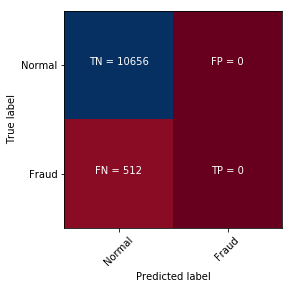

In [24]:
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()
    
plot_cm(xgb_model, y_pred)

### Our guess is true!

We can see from confusion matrix, the problem is `FALSE NEGATIVES`.

In [39]:
# I import required imbalanced learn package here to see what is required.
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

imputer = SimpleImputer()
X_imputed = imputer.fit_transform(X)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_sample(X_imputed, y)

print(X_res.shape)
print(y_res.shape)

(70978, 135)
(70978,)


In [47]:
# Wow, we got equal number of classes!
(len(y_res) - np.count_nonzero(y_res)) / np.count_nonzero(y_res)

1

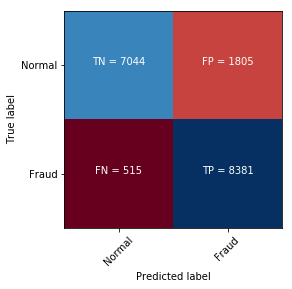

In [53]:
clf = xgb.XGBClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plot_cm(clf, y_pred)

In [54]:
print(accuracy_score(y_test, y_pred))

0.8692589461820232


In [55]:
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

Average precision-recall score: 0.938


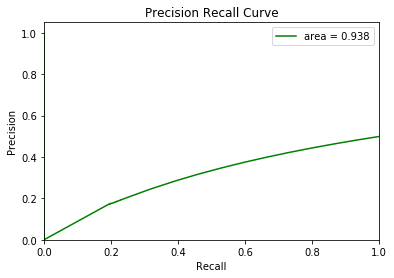

In [57]:
try:
    scores = clf.decision_function(X_test)
except:
    scores = clf.predict_proba(X_test)[:,1]
    
plot_aucprc(clf, scores)

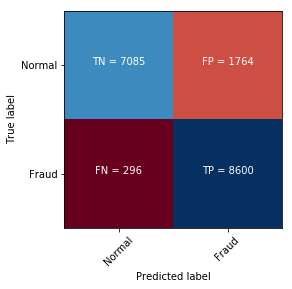

Average precision-recall score: 0.949


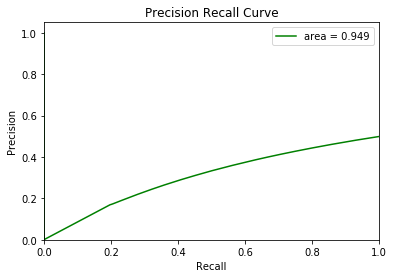

0.8839109608340378


In [62]:
from sklearn.ensemble import RandomForestClassifier
pre = RandomForestClassifier(n_jobs=-1, random_state = 42,
                             n_estimators=100,
                             max_features= 'sqrt', 
                             criterion = 'entropy')
pre.fit(X_train, y_train)
y_pred = pre.predict(X_test)
try:
    scores = pre.decision_function(X_test)
except:
    scores = pre.predict_proba(X_test)[:,1]
plot_cm(pre, y_pred)
plot_aucprc(pre, scores)
print(accuracy_score(y_test, y_pred))

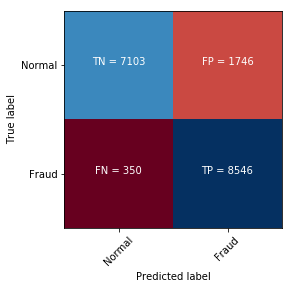

Average precision-recall score: 0.948


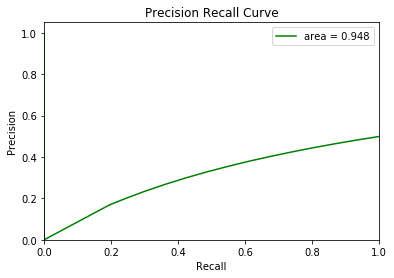

In [59]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
try:
    scores = lgb_model.decision_function(X_test)
except:
    scores = lgb_model.predict_proba(X_test)[:,1]

# Make plots
plot_cm(lgb_model, y_pred)